# Ad-hoc Pulse Shape Simulation Using Cyclic Positional U-Net (CPU-Net)
- This is the source code of training and validating the performance of CPU-Net
- This code should run on a standard python environment with PyTorch installed. The PyTorch version is 1.9.0, Nividia A100 GPU is used.
    - we recommend installing a small gadget `tqdm` to monitor the time/progress of `for` loops. Installation can be done with `pip install tqdm --user`
    - If the user do not wish to install `tqdm`, please delete the import code and tdqm() wrapper
- This repository only contains the script of the model, training data has to be downloaded separately at [here](https://drive.google.com/file/d/1JcgQy6snavgcRetFAGl0QM3OAmPTqKqt/view?usp=sharing).
- Once downloaded, please unzip it and dump it into the same folder with this script

In [9]:
import numpy as np
import os
import time
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.parameter import Parameter
from torch.nn import init
import torch.nn.functional as F
import torch.utils.data as data_utils
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import numpy as np
from torch.autograd import Variable
from scipy import sparse
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import torchsnooper
from scipy import signal
from torch import nn, einsum
import matplotlib.gridspec as gridspec
import itertools
from scipy.stats import norm

# Loading CPU-Net and support functions
from tools import get_ca, get_tail_slope, inf_train_gen, LambdaLR, weights_init_normal
from dataset import SplinterDataset, SEQ_LEN, LSPAN, RSPAN
from network import PositionalUNet, RNN
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Load Dataset
- This function loads the siggen simulation and detector pulse dataset, splitting them into training and validation data loader with 7:3 ratio
- Simulated pulses are generated in Siggen
- Detector pulses are collected from a local Ge detector

In [3]:
#Load dataset
def load_data(batch_size):
    dataset = SplinterDataset("DetectorPulses.pickle", "SimulatedPulses.pickle")

    validation_split = .3
    shuffle_dataset = True
    random_seed= 42222
    indices = np.arange(len(dataset))

    if shuffle_dataset :
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    split = int(validation_split*len(dataset))
    train_indices, val_indices = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)
    dataset.set_raw_waveform(False)
    train_loader = data_utils.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler,  drop_last=True)
    test_loader = data_utils.DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler,  drop_last=True)

    return train_loader,test_loader

## UNet Training
- Define global parameter for the training
    - DEVICE: the device for CPU-Net training, use GPU if GPU node is found, otherwise use CPU
    - BATCH_SIZE: batch size, each batch is drawn from the infinite train generator
    - ITERS: how many batch to train
    - DECAY: learning rate decay
    - LRATE: learning rate
    - target_real: a vector of 1, used for GAN discriminator training
    - target_fake: a vector of 0, used for GAN discriminator training
    

In [4]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
BATCH_SIZE = 16
ITERS = 3001
DECAY = 500
LRATE =1e-3
target_real = torch.ones(BATCH_SIZE,1).to(DEVICE)
target_fake = torch.zeros(BATCH_SIZE,1).to(DEVICE)

- Create infinite train generator. This generator can be called an infinite amount of time to draw from training dataset (with repetition)

26421


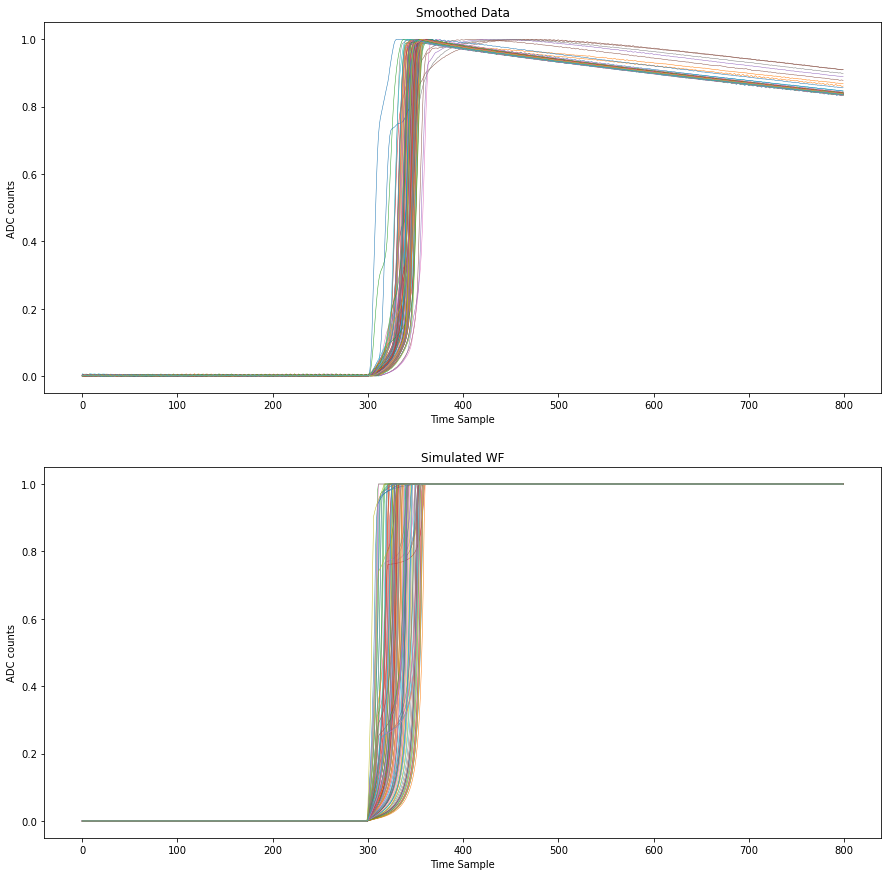

In [15]:
train_loader, test_loader = load_data(BATCH_SIZE)
data = inf_train_gen(train_loader)

- Create network structures and feed them into the DEVICE defined above
    - A: Detector Pulses
    - B: Simulated Pulses
    - BtoA: Ad-hoc Translation Network (Simulation to Data)
    - AtoB: Inverse Ad-hoc Translation Network (Data to Simulation)

In [12]:
netG_A2B = PositionalUNet()
netG_B2A = PositionalUNet()
netD_A = RNN().apply(weights_init_normal)
netD_B = RNN().apply(weights_init_normal)
netG_A2B.to(DEVICE)
netG_B2A.to(DEVICE)
netD_A.to(DEVICE)
netD_B.to(DEVICE)

RNN(
  (embedding): Embedding(1000, 64)
  (RNNLayer): GRU(64, 64, batch_first=True, bidirectional=True)
  (attention_weight): Linear(in_features=128, out_features=128, bias=False)
  (norm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fcnet): Linear(in_features=256, out_features=1, bias=True)
)

- Create loss function and set up optimizer
    - BCELoss for discriminator
    - WFDist is a special L1loss where additional weight is added to the rising and falling edge of the waveform

In [13]:
class WFDist(nn.Module):
    '''
    Waveform Distance, this is a special type of L1 loss which gives more weight to the
    rising and falling edge of each pulse
    '''
    def __init__(self):
        super(WFDist, self).__init__()
        self.criterion = nn.L1Loss()
        self.weight = torch.tensor([2.0]*LSPAN+[10.0]*150+[5.0]*(RSPAN-150)).to(DEVICE)
    
    def forward(self, x1, x2):
        loss_out = 0.0
        for i in range(x1.size(0)):
            loss_out += self.criterion(x1[i].view(-1)*self.weight, x2[i].view(-1)*self.weight)#/self.weight.sum()
        return loss_out/x1.size(0)

In [14]:
criterion_GAN = nn.BCELoss().to(DEVICE)
criterion_cycle = WFDist().to(DEVICE)
criterion_identity = WFDist().to(DEVICE)

optimizer_G = torch.optim.Adam(itertools.chain(netG_A2B.parameters(), netG_B2A.parameters()),lr=LRATE, betas=(0.5, 0.999))
optimizer_D_A = torch.optim.Adam(netD_A.parameters(), lr=LRATE, betas=(0.5, 0.999))
optimizer_D_B = torch.optim.Adam(netD_B.parameters(), lr=LRATE, betas=(0.5, 0.999))

lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=LambdaLR(ITERS, 0, DECAY).step)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=LambdaLR(ITERS, 0, DECAY).step)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=LambdaLR(ITERS, 0, DECAY).step)

- Start training

In [ ]:
from tqdm import tqdm
for iteration in tqdm(range(ITERS)):
    netG_A2B.train()
    netG_B2A.train()

    #########################
    # A: DetectorPulses
    # B: Simulated Pulses
    #########################
    
    real_A, real_B = next(data)
    real_A = real_A.to(DEVICE).float()
    real_B = real_B.to(DEVICE).float()

    ###### Generators A2B and B2A ######
    optimizer_G.zero_grad()

    # Identity loss
    # G_A2B(B) should equal B if real B is fed
    same_B = netG_A2B(real_B)
    loss_identity_B = criterion_identity(same_B, real_B)*5
    # G_B2A(A) should equal A if real A is fed
    same_A = netG_B2A(real_A)
    loss_identity_A = criterion_identity(same_A, real_A)*5

    # GAN loss
    fake_B = netG_A2B(real_A)
    pred_fake = netD_B(fake_B)
    # loss_GAN_A2B = pred_fake.mean()
    # loss_GAN_A2B.backward(target_real)
    loss_GAN_A2B = criterion_GAN(pred_fake, target_real)

    fake_A = netG_B2A(real_B)
    pred_fake = netD_A(fake_A)
    # loss_GAN_B2A = pred_fake.mean()
    # rand = torch.tensor(np.random.rand()).to(DEVICE)*0.5+0.5
    # random_real = random_real[torch.randperm(random_real.size(0))]
    loss_GAN_B2A = criterion_GAN(pred_fake,target_real)

    # Cycle loss
    recovered_A = netG_B2A(fake_B)
    loss_cycle_ABA = criterion_cycle(recovered_A, real_A)*10.0

    recovered_B = netG_A2B(fake_A)
    loss_cycle_BAB = criterion_cycle(recovered_B, real_B)*10.0

    # Total loss
    loss_G = loss_identity_A + loss_identity_B + loss_cycle_ABA + loss_cycle_BAB + loss_GAN_A2B + loss_GAN_B2A
    loss_G.backward()

    optimizer_G.step()
    ###### Discriminator A (Detector Pulses) ######
    optimizer_D_A.zero_grad()

    # Real loss
    pred_real = netD_A(real_A)
    loss_D_real = criterion_GAN(pred_real, target_real)

    # Fake loss
    pred_fake = netD_A(fake_A.detach())
    loss_D_fake = criterion_GAN(pred_fake, target_fake)


    # Total loss
    loss_D_A = loss_D_real + loss_D_fake
    loss_D_A.backward()

    optimizer_D_A.step()
    ###### Discriminator B (Simulated Pulses) ######
    optimizer_D_B.zero_grad()

    # Real loss
    pred_real = netD_B(real_B)
    loss_D_real = criterion_GAN(pred_real, target_real)

    # Fake loss
    pred_fake = netD_B(fake_B.detach())
    loss_D_fake = criterion_GAN(pred_fake, target_fake)


    # Total loss
    loss_D_B = loss_D_real + loss_D_fake
    loss_D_B.backward()



    optimizer_D_B.step()
    # ###################################

- Saving trained ATN and IATN

In [19]:
torch.save(netG_B2A.state_dict(), 'ATN.pt')
torch.save(netG_A2B.state_dict(), 'IATN.pt')

# Performance Validation
- Load the trained ATN into the device

In [20]:
ATN = PositionalUNet()
ATN.to(DEVICE)
pretrained_dict = torch.load('ATN.pt')
model_dict = ATN.state_dict()
model_dict.update(pretrained_dict) 
ATN.load_state_dict(pretrained_dict)
ATN.eval()

PositionalUNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv1d(1, 40, kernel_size=(11,), stride=(1,), padding=(5,), bias=False)
      (1): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
      (3): Conv1d(40, 40, kernel_size=(7,), stride=(1,), padding=(3,), bias=False)
      (4): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.01, inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv1d(40, 80, kernel_size=(11,), stride=(1,), padding=(5,), bias=False)
          (1): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.01, inplace=True)
          (3): Conv1d(80, 

- Reading a single batch from the test loader, translating it through the ATN

In [26]:
wf, wf_deconv, _ = next(iter(test_loader))
wf = wf.to(DEVICE)
wf_deconv = wf_deconv.to(DEVICE)
outputs  = ATN(wf_deconv)
iwf = 2 # the ith waveform in the batch to plot
detector_pulse = wf[iwf,0,:].cpu().data.numpy().flatten()
simulated_pulse = wf_deconv[iwf,0,:].cpu().data.numpy().flatten()
translated_pulse = outputs[iwf,0,:].cpu().data.numpy().flatten()

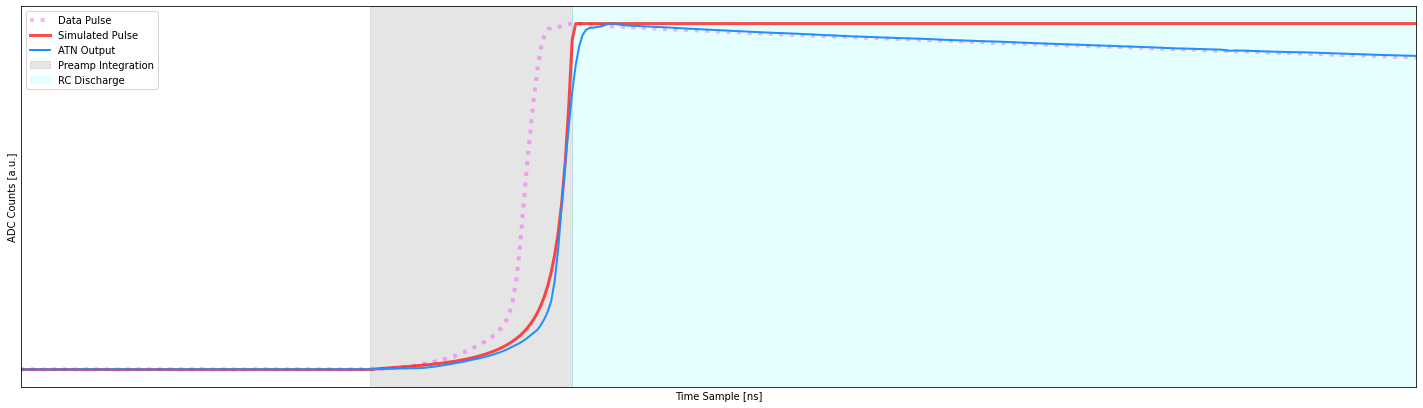

In [27]:
fig = plt.figure(figsize=(25, 7))
plt.plot(detector_pulse, label="Data Pulse",alpha=0.3, color="magenta", linestyle=":",linewidth = 4)
plt.plot(simulated_pulse, label="Simulated Pulse",alpha=0.7, color="red", linewidth = 3)
plt.plot(translated_pulse, label="ATN Output",color="dodgerblue", linewidth = 2)
plt.axvspan(xmin=300,xmax=358,alpha=0.2,color="grey", label="Preamp Integration")
plt.axvspan(xmin=358,xmax=800,alpha=0.1,color="cyan",label="RC Discharge")
plt.xticks([], [])
plt.yticks([], [])
plt.xlabel("Time Sample [ns]")
plt.ylabel("ADC Counts [a.u.]")
# ax_main.plot(orwf, label="Data->Siggen",alpha=0.3,color="green", linewidth = 5)
# plt.gca().get_xaxis().set_visible(False)
# plt.gca().get_yaxis().set_visible(False)
plt.legend(loc="upper left")
plt.xlim(200, 600)
plt.savefig("ATN.png",dpi=200)
plt.show()
plt.cla()
plt.clf()
plt.close()

- Obtain the critical reconstruction parameters of each waveform by looping through the test dataset
    - `ca`: maximal current amplitude
    - `ts`: tail slope
- Note that this code is slow, mainly because of the current amplitdue calculation

In [29]:
ts = []
gan_ts = []
ca = []
gan_ca = []
sim_ca = []
for wf, wf_deconv,rawwf in tqdm(test_loader):
    bsize = wf.size(0)
    gan_wf = netG_B2A(wf_deconv.to(DEVICE).float())
    for iwf in range(bsize):
        datawf = wf[iwf,0].cpu().numpy().flatten()
        siggenwf = wf_deconv[iwf,0].cpu().numpy().flatten()
        transfer_wf = gan_wf[iwf,0].detach().cpu().numpy().flatten()
        ts.append(get_tail_slope(datawf))
        gan_ts.append(get_tail_slope(transfer_wf))
        ca.append(get_ca(datawf))
        gan_ca.append(get_ca(transfer_wf))
        sim_ca.append(get_ca(siggenwf))

100%|██████████| 495/495 [18:05<00:00,  2.19s/it]


- Plotting the normalized tail slope

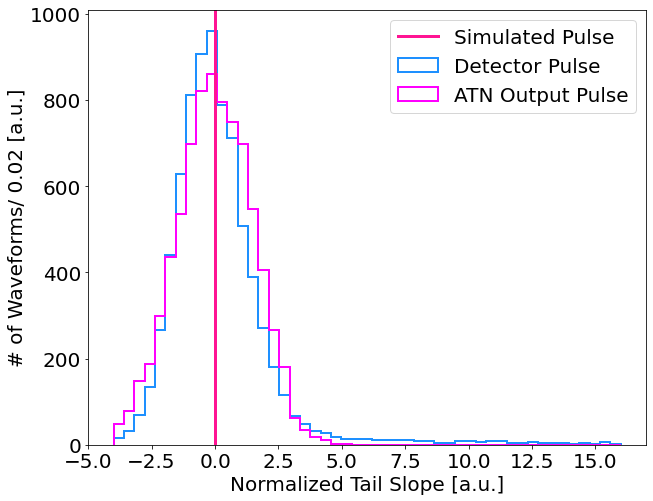

In [33]:
plt.rcParams['font.size'] = 20
plt.rcParams["figure.figsize"] = (10,8)
ts = np.array(ts)
gan_ts =np.array(gan_ts)
mean,std = norm.fit(select_quantile(ts))
rg = np.linspace(-4,16,50)
plt.hist((np.array(ts)-mean)/std,bins=rg,histtype="step",linewidth=2,density=False,color="dodgerblue",label="Detector Pulse")
mean,std= norm.fit(select_quantile(gan_ts))
plt.hist((np.array(gan_ts)-mean)/std,bins=rg,histtype="step",linewidth=2,density=False,color="magenta",label="ATN Output Pulse")
plt.axvline(x=0,color="deeppink",linewidth=3,label="Simulated Pulse")
plt.legend()
plt.ylabel("# of Waveforms/ 0.02 [a.u.]")
plt.xlabel("Normalized Tail Slope [a.u.]")
plt.savefig("tailslope.png",dpi=100)

- Plotting the maximal current amplitude

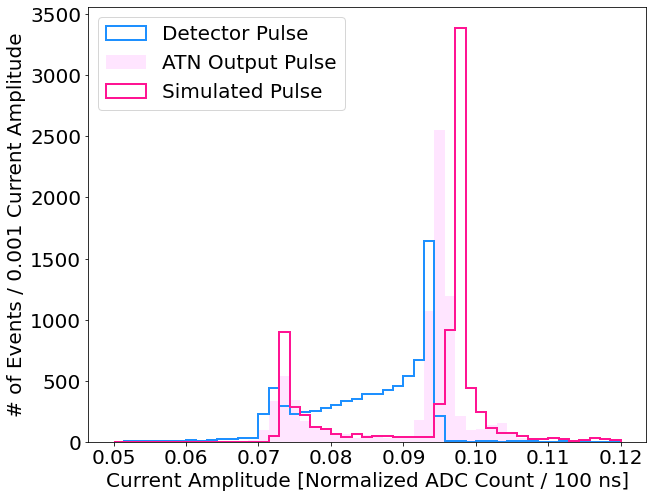

In [35]:
plt.rcParams['font.size'] = 20
plt.rcParams["figure.figsize"] = (10,8)
rg = np.linspace(0.05,0.12,50)
plt.hist(ca,bins=rg,label="Detector Pulse",histtype="step",linewidth=2,color="dodgerblue")
plt.hist(gan_ca,bins=rg,label="ATN Output Pulse",alpha=0.1,color="magenta")
plt.hist(sim_ca,bins=rg,label="Simulated Pulse",linewidth=2,histtype="step",color="deeppink")
plt.xlabel("Current Amplitude [Normalized ADC Count / 100 ns]")
plt.ylabel("# of Events / 0.001 Current Amplitude")
plt.legend(loc="upper left")
# plt.yscale("log")
plt.savefig("current_amp.png",dpi=200)